In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import lines
from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# upload data 
df = pd.read_csv('../data/for_plos.csv')
df = df.rename(columns={'key':'action'})
df_param = pd.read_csv('../results/dezfouli_trnn_param.csv')

df.loc[df["action"] == "R1", "action"] = 0
df.loc[df["action"] == "R2", "action"] = 1

df['action'] = df['action'].astype(int)
df['reward'] = df['reward'].astype(int)
df['block'] = df['block'] - 1

# create unique list of names
UniqueNames = df.ID.unique()
dic = {}
for i in range(101):
    dic[UniqueNames[i]] = i
for i in range(101):
    df.loc[df.ID == UniqueNames[i], 'ID'] = dic[UniqueNames[i]]
df = df.rename(columns={'ID':'subject'}).copy()

label = []
for i in range(101):
    if 'B' in df[df.subject==i].diag.values[0]:
        label.append(0)
    elif 'D' in df[df.subject==i].diag.values[0]:
        label.append(1)
    else:
        label.append(2)    
z = []
b = []
d = []
h = []
idx = [] 

for i in range(101):
    if label[i] == 0:
        b.append(df[df.subject==i]) 
    elif label[i] == 1:
        d.append(df[df.subject==i])
    else:
        h.append(df[df.subject==i])
       
        
for i in range(len(b)):
    z.append(b[i])
    idx.append(np.repeat(i,len(b[i])))
    
last_i = i+1
    
for i in range(len(d)):
    z.append(d[i])
    idx.append(np.repeat(last_i+i,len(d[i])))

last_i = last_i+i+1

for i in range(len(h)):
    z.append(h[i])
    idx.append(np.repeat(last_i+i,len(h[i])))

df = pd.concat(z).reset_index().drop(columns='index')
df['subject'] = np.concatenate(idx)

all_data = []
n_trials = []

for i in range(101):
    cur_df = df[(df['subject']==i)].reset_index()
    all_data.append(cur_df)
    n_trials.append(len(cur_df))


df_full = df.join(df_param.drop(columns='subject'))
df_full['stay'] = (df_full.action.shift(1)==df_full.action).astype(int)

a = []
for i in range(101):
    for j in range(12):
        x = len(df_full[(df_full.subject==i) & (df_full.block==j)])
        a.append(np.arange(x))
        
df_full['trial_b'] = np.concatenate(a)

a = []
for i in range(101):
    x = len(df_full[(df_full.subject==i)])
    a.append(np.arange(x))
                     
df_full['trial'] = np.concatenate(a)

In [3]:
dezfouli_bay = np.array([0.43299282, 0.4723734 , 0.34667342, 0.17068176, 0.2724769 ,
       0.60895996, 0.22709608, 0.61567178, 0.29702875, 0.46074022,
       0.45463701, 0.24728675, 0.53504052, 0.19376093, 0.18843351,
       0.11373874, 0.2109396 , 0.66840222, 0.64379125, 0.44288437,
       0.52499192, 0.44405116, 0.07269716, 0.39149199, 0.49164171,
       0.13904366, 0.50537035, 0.33653283, 0.27061942, 0.59042738,
       0.21568214, 0.33002981, 0.66182744, 0.39574672, 0.38802981,
       0.56935314, 0.06493288, 0.24096051, 0.59718313, 0.11141427,
       0.48043681, 0.14145698, 0.45414734, 0.64659469, 0.47263908,
       0.33074152, 0.42475272, 0.26027435, 0.3837441 , 0.13805425,
       0.57523694, 0.68089935, 0.54156256, 0.20371408, 0.14080176,
       0.11908749, 0.30168512, 0.4039803 , 0.15283749, 0.34700756,
       0.47720297, 0.58576724, 0.41334855, 0.16824946, 0.19441756,
       0.50347399, 0.3987142 , 0.16842989, 0.3411529 , 0.12360423,
       0.36136018, 0.20266524, 0.2920222 , 0.45521117, 0.21614925,
       0.30418165, 0.4933597 , 0.48239314, 0.19611432, 0.42852659,
       0.2754341 , 0.1603272 , 0.1294155 , 0.12497313, 0.22016773,
       0.57815781, 0.24636687, 0.07267015, 0.28179413, 0.22045088,
       0.123525  , 0.05388839, 0.23980084, 0.24339555, 0.36781444,
       0.28823071, 0.12079522, 0.08809483, 0.14668342, 0.12799825,
       0.47542049])

dezfouli_ind = pd.read_csv('../results/dezfouli_individual_theoretical.csv')['bce'].values
dezfouli_trnn = pd.read_csv('../results/dezfouli_trnn.csv')['bce'].values
dezfouli_drnn =  pd.read_csv('../results/dezfouli_drnn.csv')['bce'].values
diag = pd.read_csv('../results/dezfouli_individual_theoretical.csv')['diag'].values

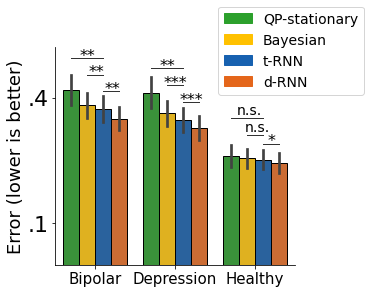

In [4]:
x = sns.blend_palette(['tab:green','#ffc100','#D2292D','grey','#1761B0'])[2]
pla = ['tab:green','#ffc100','#1761B0',x]

df_dezfouli = pd.DataFrame({'dezfouli_theoretical':dezfouli_ind,
                            'dezfouli_bay':dezfouli_bay,
                            'dezfouli_trnn':dezfouli_trnn,
                            'dezfouli_drnn':dezfouli_drnn})

df_dezfouli_t = pd.DataFrame({'bce':df_dezfouli.values.T.flatten(),
                             'Model':np.repeat(['QP stationary', 'Bayesian', 't-RNN','d-RNN'],101),
                             'data':np.repeat('Dezfouli',101*4),
                             'Diag':np.tile(diag,4)
                             })

fig , ax = plt.subplots(1,1,figsize=(4.3,4))

sns.barplot(ax=ax,data=df_dezfouli_t, x='Diag',y='bce',hue='Model',palette=pla,edgecolor='k',errorbar="se")
ax.set_xticklabels(['Bipolar','Depression','Healthy'],fontsize=15)
ax.set_xlabel('',size=18)

legend_elements = [
                Patch([0],[0] ,color=pla[0], label='QP-stationary'),
                Patch([0],[0] ,color=pla[1], label='Bayesian'),
                Patch([0],[0] ,color=pla[2], label='t-RNN'),
                Patch([0],[0] ,color=pla[3], label='d-RNN')
]

# loc='lower right',framealpha=0.9)


ax.set_ylim(0,.52)
ax.set_yticks([.1,.4])
ax.set_yticklabels([.1,.4],fontsize=22)
ax.set_ylabel('Error (lower is better)',size=18,labelpad=2)

ax.set_yticklabels([str(x)[1:] for x in np.round(ax.get_yticks(), 3)])

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]

h = 0.00*yrange

line = lines.Line2D([-.3,-.3,0.1,0.1], [.495,.495+h,.495+h,.495], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('**', xy=(np.mean([-.3, 0.1]),.48),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)

line = lines.Line2D([-.1,-.1,0.1,0.1], [.455,.455+h,.455+h,.455], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('**', xy=(np.mean([-.08, 0.1]),.44),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)


line = lines.Line2D([0.1,0.1,0.3,0.3], [.415,.415+h,.415+h,.415], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('**', xy=(np.mean([0.12, 0.3]),.40),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)

###############################################################################

line = lines.Line2D([0.7,0.7,1.1,1.1], [.47,.47+h,.47+h,.47], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('**', xy=(np.mean([0.7, 1.1]),.455),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)

line = lines.Line2D([0.9,0.9,1.1,1.1], [.43,.43+h,.43+h,.43], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('***', xy=(np.mean([.9, 1.1]),.415),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)


line = lines.Line2D([1.1,1.1,1.3,1.3], [.39,.39+h,.39+h,.39], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('***', xy=(np.mean([1.1, 1.3]),.375),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)


###############################################################################

line = lines.Line2D([1.7,1.7,2.1,2.1], [.35,.35+h,.35,.35], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('n.s.', xy=(np.mean([1.75, 2.1]),.35),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=14, clip_on=False, annotation_clip=False)

line = lines.Line2D([1.9,1.9,2.1,2.1], [.31,.31+h,.31+h,.31], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('n.s.', xy=(np.mean([1.95, 2.1]),.31),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=14, clip_on=False, annotation_clip=False)


line = lines.Line2D([2.1,2.1,2.3,2.3], [.29,.29+h,.29+h,.29], lw=1, c='0.2', transform=ax.transData)
line.set_clip_on(False)
ax.add_line(line)
ax.annotate('*', xy=(np.mean([2.1, 2.3]),.275),
            xytext=(0, 1), textcoords='offset points',
            xycoords='data', ha='center', va='bottom',
            fontsize=16, clip_on=False, annotation_clip=False)



ax.legend(handles=legend_elements,fontsize=14,bbox_to_anchor=(0.65, 0.75))

sns.despine()
plt.savefig('../plots/fig_3A_REV.pdf',bbox_inches='tight')
plt.show()


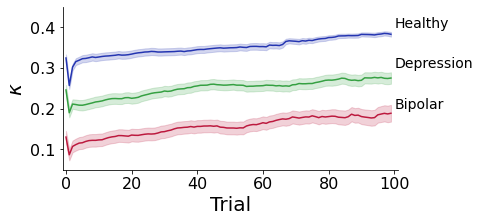

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

co = ['#bc193e', '#35a042', '#2435b1','#f79605']

z_0 = df_full[df_full.diag=='Bipolar'].groupby('trial_b').mean().kappa.values[2:100]
z_1 = df_full[df_full.diag=='Bipolar'].groupby('trial_b').sem().kappa.values[2:100]
ax.plot(z_0,color=co[0])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[0],alpha=.2)

z_0 = df_full[df_full.diag=='Depression'].groupby('trial_b').mean().kappa.values[2:100]
z_1 = df_full[df_full.diag=='Depression'].groupby('trial_b').sem().kappa.values[2:100]
ax.plot(z_0,color=co[1])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[1],alpha=.2)

z_0 = df_full[df_full.diag=='Healthy'].groupby('trial_b').mean().kappa.values[2:100]
z_1 = df_full[df_full.diag=='Healthy'].groupby('trial_b').sem().kappa.values[2:100]
ax.plot(z_0,color=co[2])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[2],alpha=.2)

ax.set_xlabel('trial_b',size=20)
ax.set_ylabel('$\u03BA$',size=20)
ax.tick_params(axis='both', which='major', labelsize=14)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


ax.set_xlim(-1,101)
ax.set_ylim(0.05,.45)

ax.text(x=100,y=0.2,s='Bipolar',fontsize=14)
ax.text(x=100,y=0.3,s='Depression',fontsize=14)
ax.text(x=100,y=0.4,s='Healthy',fontsize=14)
ax.set_xticks([0,20,40,60,80,100])
ax.set_xticklabels([0,20,40,60,80,100],fontsize=16)

ax.set_xlabel('Trial',size=20)

plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

sns.despine()
plt.savefig('../plots/fig_3E_REV.pdf',bbox_inches='tight')
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

co = ['#bc193e', '#35a042', '#2435b1','#f79605']

z_0 = df_full[df_full.diag=='Bipolar'].groupby('trial_b').mean().beta.values[2:100]
z_1 = df_full[df_full.diag=='Bipolar'].groupby('trial_b').sem().beta.values[2:100]
ax.plot(z_0,color=co[0])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[0],alpha=.2)

z_0 = df_full[df_full.diag=='Depression'].groupby('trial_b').mean().beta.values[2:100]
z_1 = df_full[df_full.diag=='Depression'].groupby('trial_b').sem().beta.values[2:100]
ax.plot(z_0,color=co[1])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[1],alpha=.2)

z_0 = df_full[df_full.diag=='Healthy'].groupby('trial_b').mean().beta.values[2:100]
z_1 = df_full[df_full.diag=='Healthy'].groupby('trial_b').sem().beta.values[2:100]
ax.plot(z_0,color=co[2])
ax.fill_between(np.arange(len(z_0)),z_0+z_1,z_0-z_1, color=co[2],alpha=.2)

ax.set_xlabel('trial_b',size=16)
ax.set_ylabel(r'$\beta$',size=20)
ax.tick_params(axis='both', which='major', labelsize=14)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

ax.set_xlim(-1,101)

legend_elements = [
                Line2D([0],[0] ,lw=2, color=co[0], label='Bipolar'),
                Line2D([0],[0] ,lw=2, color=co[1], label='Depression'),
                Line2D([0],[0] ,lw=2, color=co[2], label='Healthy')
                
]
ax.legend(handles=legend_elements,fontsize=14,loc='center left',framealpha=0.5)
ax.set_xticks([0,20,40,60,80,100])
ax.set_xticklabels([0,20,40,60,80,100],fontsize=16)

ax.set_xlabel('Trial',size=16)

plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)

sns.despine()
plt.savefig('../plots/fig_beta_dynamics_REV.pdf',bbox_inches='tight')
plt.show()
